## HPGe calibration - tutorial

### 1.从文件中读取能谱

In [1]:
//%jsroot on
TCanvas *c1 = new TCanvas("c1");

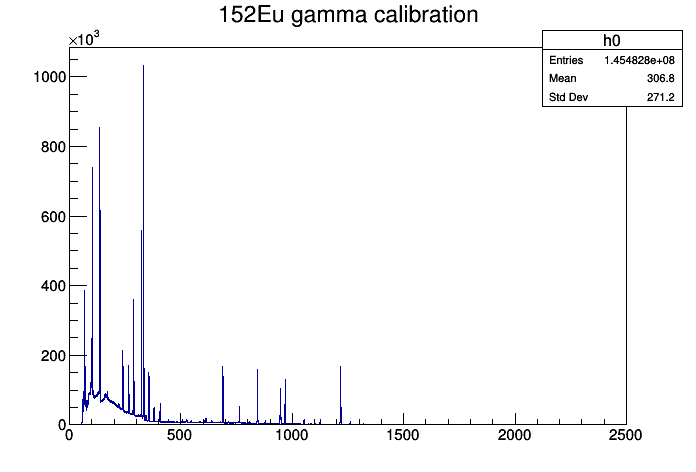

In [2]:
// 从文件中读取能谱

TFile *filer = new TFile("gamma.root","READ");// 以只读模式打开ROOT文件
if(!filer->IsOpen())
  {
    std::cout<<"Can't open root file"<<std::endl;
  }

TH1F *h_gammaraw = (TH1F*)filer->Get("h0");//通过指针读取原始gamma谱
// 通过指针 h_gammaraw 可对直方图进行操作

h_gammaraw->Draw();
c1->Draw();


- 开启 jsroot on，可以操作图像对数坐标显示。也可以拖动局部显示图像。
- 将鼠标放置在图像左下角的实心方块上，会显示很多小按钮。探索一下每个按钮的功能

上图为未刻度的gamma谱，其中横轴为道址，纵轴为计数。进行刻度时参照刻度方法中给出的$^{152}Eu$和$^{133}Ba$能谱，查找到对应峰位进行刻度。

### 2.最小二乘法拟合

#### Gauss 拟合

 -  拟合能量峰位的时候可以采用Gauss拟合。
 
下图是Gauss拟合中返回的拟合参数的一个示例。
其中constant、mean、sigma，的Values 分别代表着高斯函数的高度、峰位、和展宽的拟合值。上述每项对应的Error为该项的拟合误差。
 - 峰位的拟合误差应选用mean对应的Error值，而非sigma值。

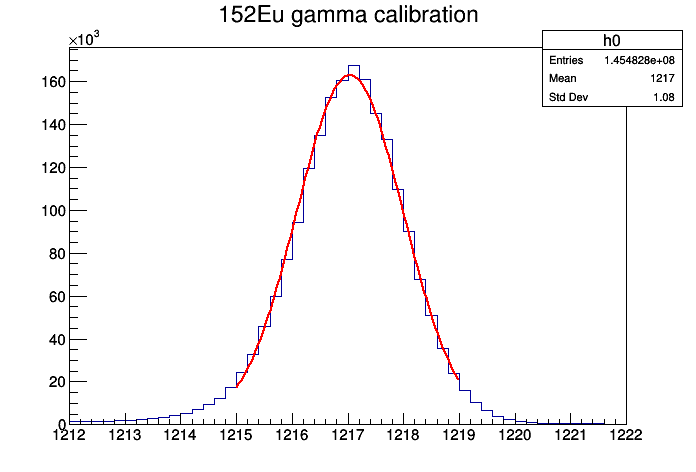

 FCN=1802.86 FROM MIGRAD    STATUS=CONVERGED      71 CALLS          72 TOTAL
                     EDM=1.33436e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.62855e+05   1.56384e+02   2.45958e+00   1.93285e-06
   2  Mean         1.21705e+03   7.78963e-04   5.80332e-04  -5.41540e-01
   3  Sigma        9.58711e-01   7.45859e-04   4.33426e-06  -2.37135e-02


In [3]:
// 对某个峰进行高斯拟合
h_gammaraw->Fit("gaus","","",1215,1219);// 这里 1215 为拟合的左边界，1219 为拟合的右边界
h_gammaraw->Draw();
h_gammaraw->GetXaxis()->SetRangeUser(1212,1222);//设置显示的区间
c1->Draw();

// 拟合需要选择合适的拟合区间。
// 由拟合输出信息可以获得峰位及误差信息。
// 这里需要注意，选取合适的拟合区间对于峰位的精确指认至关重要。评判拟合好坏的一个标准是拟合曲线与实际曲线越贴近越好。

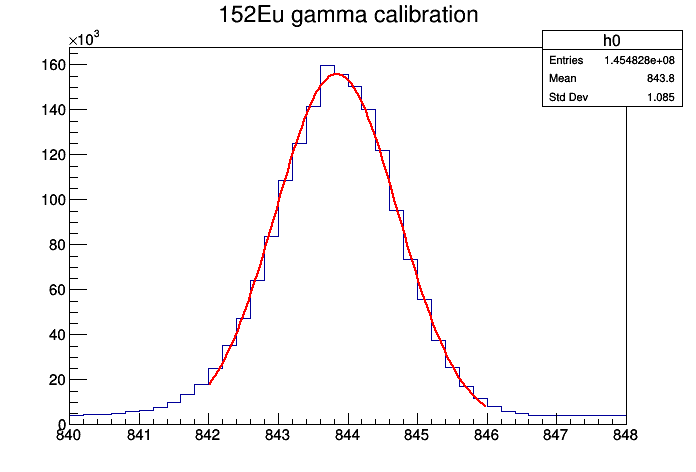

 FCN=1896.87 FROM MIGRAD    STATUS=CONVERGED      65 CALLS          66 TOTAL
                     EDM=3.62692e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.55787e+05   1.57079e+02   2.56202e+00   4.72206e-07
   2  Mean         8.43845e+02   7.40902e-04   4.02377e-04   1.48275e-01
   3  Sigma        8.78059e-01   6.65767e-04   4.27239e-06  -6.73589e-01


In [4]:
h_gammaraw->GetXaxis()->SetRangeUser(0,2500);//返回全区间，在多次进行拟合时，必须要有这个操作，否则指定的拟合区间将存在问题
h_gammaraw->Fit("gaus","","",842,846);//指定拟合的左右边界， 在Fit函数的第二个参数设为"L"时进行最大似然法拟合
h_gammaraw->Draw();
h_gammaraw->GetXaxis()->SetRangeUser(840,848);//设置显示的区间
c1->Draw();

### 自定义拟合函数
 - 拟合gauss峰的sigma时需要考虑峰下的本底的影响，仅采用Gauss函数进行拟合不能正确估计gauss峰的sigma以及峰的面积。
 - 当本底线性变化时，可采用 高斯+线性函数作为拟合函数

### 拟合用的自定义函数 定义方法
 - par[n]：代表拟合参数，n为从0开始数起的第n个参数
 - x[0]：为一维函数变量

In [5]:
double fun(double *x, double *par)//高斯函数par[0-2]+线性函数par[3-4]
{
   return  par[0]*TMath::Exp(-0.5*((x[0]-par[1])/par[2]) * ((x[0]-par[1])/par[2])) + par[3]+x[0]*par[4];
}

### 拟合函数的参数初值设定+拟合
- 除了Gaus，poln(多项式)等简单拟合函数外，其他拟合函数一般要在拟合前给定合理的初值，才能正确收敛到正确的初值。如果初始值指定与实际值偏离很远，拟合结果有可能不收敛。
<img src="minimum.png" alt="minimum" style="zoom:50%;" />
- 如对于下图的拟合：
  - gauss函数初值中的par[0]-par[2]可设为仅用gauss函数拟合得到的constant,mean,sigma值
  - 线性函数的b即par[3]可设为峰左右的平台平均高度，斜率k,即par[4]可设为比较小的值。
    - 也可在峰左右的线性区域，进行线性拟合得到对应的par[3],par[4]的值。

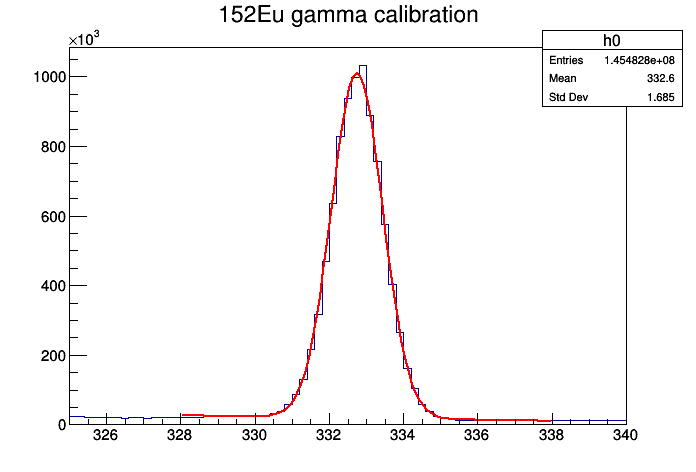

 FCN=11800.6 FROM MIGRAD    STATUS=CONVERGED     230 CALLS         231 TOTAL
                     EDM=3.97217e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  p0           9.90319e+05   4.34549e+02   1.82325e+01  -8.76115e-08
   2  p1           3.32757e+02   2.53158e-04   1.58671e-04   2.43985e-01
   3  p2           6.94658e-01   2.09445e-04   8.47587e-06   6.36313e-02
   4  p3           5.48158e+05   2.29810e+03   1.21573e+00   1.90946e-06
   5  p4          -1.59114e+03   6.87337e+00   3.63744e-03   6.42152e-04


In [6]:
TF1 *ffit = new TF1("ffit",fun,0,2500,5);// 0 跟 2500 为 左右边界， 5 表示总共有五个参数
ffit->SetParameter(0,1.0e6);//par[0]-高斯函数高度
ffit->SetParameter(1,332.0);//par[1]-高斯函数峰中心
ffit->SetParameter(2,1.0);//par[2]-高斯函数sigma
ffit->SetParameter(3,1.0e3);//par[3]-线性函数零次项
ffit->SetParameter(4,0.01);//par[4]-线性函数一次项

h_gammaraw->GetXaxis()->SetRangeUser(0,2500);//返回全区间
h_gammaraw->Fit("ffit","","",328,338);
h_gammaraw->Draw();
h_gammaraw->GetXaxis()->SetRangeUser(325,340);//X轴的显示范围
c1->Draw();

## 将数据填入 TGraphErrors 进行拟合

第一章的作业中用到的 TGraph，一般用来表达没有误差的二维数据点的分布。当数据有误差时需要用 TGraphErrors，如以上拟合得到的峰位值有误差值。

仿照下面链接 [TGraphErrors Class Reference](https://root.cern.ch/doc/master/classTGraphErrors.html) 的做法，将数据(包含误差值)填入TGraphErrors,并画图。$^{152}Eu$，$^{133}Ba$ 的能量值 [keV] 的误差全部设置为0。

关于 TGraphErrors 的使用，也可参考 jupyter 上 ROOT Tutorial/TGraph.ipynb 文件中关于 TGraphErrors 的实例。实例中包含了如何进行数据点的拟合。

关于ROOT fit的更详细用法参考以下链接 [FittingHistograms](https://root.cern.ch/root/htmldoc/guides/users-guide/FittingHistograms.html)


## 应用获得的刻度系数绘制 𝛾 能谱

在获得能量刻度系数之后，应用刻度系数即可获得刻度后的能谱。然而直接对直方图进行变换会出现一些并道的问题，这里不做过多阐述。简化起见，提供如下示例代码，供大家应用刻度系数直接生成刻度后的能谱。


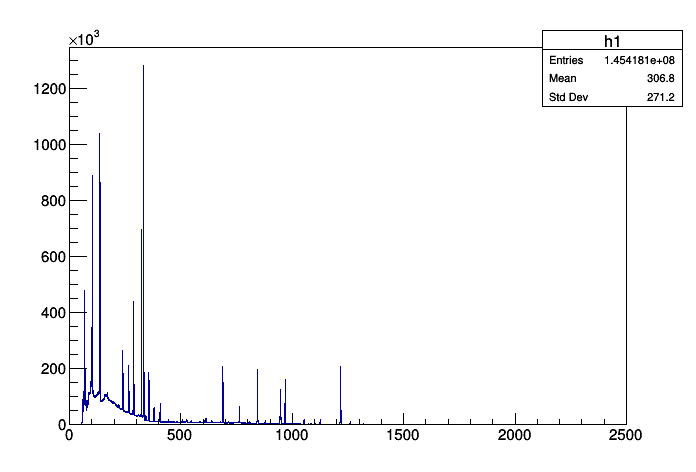

In [7]:
    double p0 = 0;//填入拟合得到的数值
    double p1 = 1;
    double p2 = 0;
    TH1D *h1 = new TH1D("h1","",10000,0,2500);//h1为刻度后的gamma谱
    TRandom3 *r = new TRandom3(0);
    int Nbins = h0->GetXaxis()->GetNbins(); //h0为未刻度的gamma谱。
    for(int i=0; i<Nbins; i++)
    {
        
        Long64_t eN = h0->GetBinContent(i);// GetBinContent()提取每个bin的计数
        Double_t e = h0->GetBinLowEdge(i);// GetBinLowEdge()提取每个bin左边界的横坐标x。
        for(Long64_t j=0; j<eN; j++)
        {
            Double_t ea = e+r->Rndm()*0.2;// 思考下为何要加上一个随机数？？？？？？？？？？？？？？
            ea=p2*ea*ea+p1*ea+p0;//p0,p1,p2为上面获得的二次项刻度系数。
            h1->Fill(ea);
        }
    }
h1->Draw();
c1->Draw();


刻度好的$\gamma$峰的能量值应与下图标示数值接近。
![](gamma.png)

### 3. 计算gamma峰面积(峰计数)

计算峰面积采用HPGe gamma 探测器刻度方法中给出的面积求法。应用高斯加线性拟合获得的sigma参数，选取mean-1.5*sigma，mean+1.5*sigma范围，进行积分。获得峰位总计数S1。
在峰附近左右两侧各选择1.5*sigma范围进行积分，获得S2,S3，用于估计峰的本底。
从而可以获得质子峰计数S=S1-S2-S3.
![](16.png)

**如何从直方图中提取面积**

如下图，若要获得红线区域内面积，需要提取出拟合范围左右边界的binx项。
![](17.png)
```cpp
int bin1=h0->FindBin(686.9);//686.9为积分左边界，对应bin值3435
int bin2=h0->FindBin(689.9);//689.9为积分右边界，对应bin值3450
h0->Integral(bin1,bin2);//计算区域总计数
```
即可获得区域内总计数。

In [8]:
!jupyter nbconvert HpGe_gamma_calibration_code.ipynb --to html

[NbConvertApp] Converting notebook HpGe_gamma_calibration_code.ipynb to html

[NbConvertApp] Writing 367260 bytes to HpGe_gamma_calibration_code.html

